# Churn Analysis Plan

## Major Assumptions
Analysis will focus on August 2024 churn patterns compared to monthly trends across 2023-2024 using the fct_creator_monthly_performance table as the primary data source. We assume this table contains creator-level monthly metrics that can be used to derive churn (creators who were active in previous month but not current month), that the data is complete for the 2023-2024 timeframe, and that creator activity status can be reliably determined from performance metrics. The analysis will calculate churn as the percentage of creators who stop being active month-over-month.

## Plan
- [x] Data discovery and metric definition
  - [x] Query dbt documentation and Databricks schema to identify churn-related tables, metrics, and customer dimensions
  - [x] Validate data completeness and define churn calculation methodology (customer count, revenue-based, or cohort-based)
  - [x] Calculate actual churn from patron movement since churned_patrons column is empty
- [x] Monthly churn trend analysis (2023-2024)
  - [x] Calculate monthly churn rates and creator counts across all months in the timeframe
  - [x] Create time series visualizations comparing August 2024 to historical monthly patterns
- [x] August 2024 deep dive and comparative analysis
  - [x] Segment August 2024 churn by creator characteristics (category, plan type, country)
  - [x] Analyze churn patterns by creator performance metrics (MRR, patron count tiers)
  - [x] Compare August 2024 segments to historical averages
- [x] Insights and recommendations
  - [x] Summarize key findings on August 2024 churn anomalies or patterns
  - [x] Provide actionable recommendations based on identified churn drivers

## Analysis Complete ✅

All objectives achieved. The analysis revealed that August 2024's 72.16% churn rate is not an anomaly but part of a sustained platform-wide decline from 2023 levels. Key recommendations focus on payment infrastructure, first-month retention, and fundamental product changes.

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from databricks import sql

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Get Databricks connection details from environment
db_host = os.getenv('DATABRICKS_CONNECTION_URL').replace('https://', '')
db_http_path = os.getenv('DATABRICKS_WAREHOUSE_HTTP_PATH')
db_token = os.getenv('DATABRICKS_ACCESS_TOKEN')
db_catalog = os.getenv('DATABRICKS_CATALOG')

print(f"Databricks Host: {db_host}")
print(f"Catalog: {db_catalog}")
print(f"Connection configured successfully")

Databricks Host: dbc-789165f8-da9f.cloud.databricks.com
Catalog: patreon_dev
Connection configured successfully


In [7]:
# Discover catalogs and schemas first
cursor = connection.cursor()

# Get catalogs
cursor.execute("SHOW CATALOGS")
catalogs = cursor.fetchall()
print("Available Catalogs:")
for cat in catalogs:
    print(f"  - {cat[0]}")

# Get schemas in patreon_dev catalog
print(f"\nSchemas in {db_catalog}:")
cursor.execute(f"SHOW SCHEMAS IN {db_catalog}")
schemas = cursor.fetchall()
for schema in schemas:
    print(f"  - {schema[0]}")

cursor.close()

Available Catalogs:
  - patreon_dev
  - samples
  - system
  - workspace

Schemas in patreon_dev:
  - analytics
  - analytics_marts
  - analytics_raw
  - analytics_staging
  - dbt_ah
  - default
  - information_schema
  - public


In [8]:
# Get all tables in the analytics schema
cursor = connection.cursor()

cursor.execute(f"SHOW TABLES IN {db_catalog}.analytics")
tables = cursor.fetchall()

print(f"Tables in {db_catalog}.analytics:")
print("-" * 60)
for table in tables:
    print(f"  {table[1]}")

cursor.close()

Tables in patreon_dev.analytics:
------------------------------------------------------------
  metricflow_time_spine
  my_first_dbt_model


In [9]:
# Check the other schemas for more tables
cursor = connection.cursor()

for schema_name in ['analytics_marts', 'analytics_staging', 'analytics_raw']:
    cursor.execute(f"SHOW TABLES IN {db_catalog}.{schema_name}")
    tables = cursor.fetchall()
    print(f"\nTables in {db_catalog}.{schema_name}:")
    print("-" * 60)
    for table in tables:
        print(f"  {table[1]}")

cursor.close()


Tables in patreon_dev.analytics_marts:
------------------------------------------------------------
  fct_creator_monthly_performance

Tables in patreon_dev.analytics_staging:
------------------------------------------------------------
  stg_creators
  stg_engagement_events
  stg_patrons
  stg_pledges
  stg_posts
  stg_tiers
  stg_transactions

Tables in patreon_dev.analytics_raw:
------------------------------------------------------------
  creators
  engagement_events
  patrons
  pledges
  posts
  tiers
  transactions


In [10]:
# Explore the fct_creator_monthly_performance table structure
cursor = connection.cursor()

query = f"""
SELECT * 
FROM {db_catalog}.analytics_marts.fct_creator_monthly_performance
LIMIT 5
"""

cursor.execute(query)
sample_data = cursor.fetchall()
columns = [desc[0] for desc in cursor.description]

df_sample = pd.DataFrame(sample_data, columns=columns)
print("fct_creator_monthly_performance table structure:")
print(f"Shape: {df_sample.shape}")
print(f"\nColumns: {list(df_sample.columns)}")
print(f"\nSample data:")
print(df_sample.head())

cursor.close()

fct_creator_monthly_performance table structure:
Shape: (5, 41)

Columns: ['creator_month_key', 'creator_id', 'month_start_date', 'creator_name', 'creator_category', 'plan_type', 'creator_country', 'total_patrons', 'active_patrons', 'new_patrons', 'churned_patrons', 'net_patron_change', 'patron_churn_rate_pct', 'gross_mrr_usd', 'new_mrr_usd', 'churned_mrr_usd', 'mrr_change_usd', 'mrr_growth_rate_pct', 'gross_revenue_usd', 'platform_fees_usd', 'processing_fees_usd', 'net_creator_earnings_usd', 'collection_rate_pct', 'successful_transactions', 'failed_transactions', 'declined_amount_usd', 'decline_rate_pct', 'tier_1_patrons', 'tier_2_patrons', 'tier_3_plus_patrons', 'avg_pledge_amount_usd', 'posts_published', 'paywalled_posts', 'free_posts', 'total_views', 'total_likes', 'total_comments', 'engaged_patrons', 'total_engagement_score', 'patron_engagement_rate_pct', 'updated_at']

Sample data:
                  creator_month_key creator_id month_start_date  \
0  b0a92e778bb272eb656a97c3b5791

In [11]:
# Load the full dataset for 2023-2024 analysis
cursor = connection.cursor()

query = f"""
SELECT 
    month_start_date,
    creator_id,
    creator_category,
    plan_type,
    creator_country,
    total_patrons,
    active_patrons,
    new_patrons,
    churned_patrons,
    net_patron_change,
    patron_churn_rate_pct,
    gross_mrr_usd,
    new_mrr_usd,
    churned_mrr_usd,
    mrr_change_usd,
    net_creator_earnings_usd,
    avg_pledge_amount_usd
FROM {db_catalog}.analytics_marts.fct_creator_monthly_performance
WHERE month_start_date >= '2023-01-01' 
  AND month_start_date <= '2024-12-31'
ORDER BY month_start_date, creator_id
"""

cursor.execute(query)
data = cursor.fetchall()
columns = [desc[0] for desc in cursor.description]
df = pd.DataFrame(data, columns=columns)

cursor.close()

# Convert date column to datetime
df['month_start_date'] = pd.to_datetime(df['month_start_date'])

# Convert numeric columns
numeric_cols = ['total_patrons', 'active_patrons', 'new_patrons', 'churned_patrons', 
                'net_patron_change', 'patron_churn_rate_pct', 'gross_mrr_usd', 
                'new_mrr_usd', 'churned_mrr_usd', 'mrr_change_usd', 
                'net_creator_earnings_usd', 'avg_pledge_amount_usd']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")
print(f"Date range: {df['month_start_date'].min()} to {df['month_start_date'].max()}")
print(f"Unique creators: {df['creator_id'].nunique()}")
print(f"Unique months: {df['month_start_date'].nunique()}")

Dataset loaded: 11574 rows, 17 columns
Date range: 2023-01-01 00:00:00 to 2024-12-01 00:00:00
Unique creators: 500
Unique months: 24


## Data Overview

We've successfully loaded the dataset with:
- **11,574 creator-month records** from January 2023 to December 2024
- **500 unique creators** tracked across **24 months**
- Key churn metrics available: `churned_patrons`, `patron_churn_rate_pct`, and `churned_mrr_usd`

The analysis will examine patron churn patterns (patrons leaving creators) at the platform level, with a focus on August 2024 compared to historical trends.

In [12]:
# Calculate monthly platform-level churn metrics
monthly_churn = df.groupby('month_start_date').agg({
    'total_patrons': 'sum',
    'active_patrons': 'sum',
    'new_patrons': 'sum',
    'churned_patrons': 'sum',
    'churned_mrr_usd': 'sum',
    'gross_mrr_usd': 'sum',
    'creator_id': 'count'  # Number of active creators
}).reset_index()

monthly_churn.columns = ['month', 'total_patrons', 'active_patrons', 'new_patrons', 
                         'churned_patrons', 'churned_mrr_usd', 'gross_mrr_usd', 'active_creators']

# Calculate platform-wide churn rate
monthly_churn['platform_churn_rate_pct'] = (monthly_churn['churned_patrons'] / 
                                             monthly_churn['total_patrons'] * 100).round(2)

# Calculate MRR churn rate
monthly_churn['mrr_churn_rate_pct'] = (monthly_churn['churned_mrr_usd'] / 
                                        monthly_churn['gross_mrr_usd'] * 100).round(2)

# Add year-month label for easier reading
monthly_churn['year_month'] = monthly_churn['month'].dt.strftime('%Y-%m')

print("Monthly Platform Churn Summary:")
print(monthly_churn[['year_month', 'active_creators', 'total_patrons', 'churned_patrons', 
                      'platform_churn_rate_pct', 'churned_mrr_usd', 'mrr_churn_rate_pct']].to_string(index=False))

Monthly Platform Churn Summary:
year_month  active_creators  total_patrons  churned_patrons  platform_churn_rate_pct  churned_mrr_usd  mrr_churn_rate_pct
   2023-01              140            160                0                      0.0              0.0                 0.0
   2023-02              437            992                0                      0.0              0.0                 0.0
   2023-03              497           2580                0                      0.0              0.0                 0.0
   2023-04              500           4216                0                      0.0              0.0                 0.0
   2023-05              500           5968                0                      0.0              0.0                 0.0
   2023-06              500           7455                0                      0.0              0.0                 0.0
   2023-07              500           8620                0                      0.0              0.0             

In [13]:
# Investigate the raw data to understand churn metrics better
print("Sample of raw data with all numeric columns:")
print(df[['month_start_date', 'creator_id', 'total_patrons', 'active_patrons', 
          'new_patrons', 'churned_patrons', 'net_patron_change', 'patron_churn_rate_pct',
          'churned_mrr_usd', 'gross_mrr_usd']].head(20))

print("\n" + "="*80)
print("\nDescriptive statistics for churn metrics:")
print(df[['churned_patrons', 'patron_churn_rate_pct', 'churned_mrr_usd']].describe())

print("\n" + "="*80)
print("\nChecking for non-zero churn values:")
print(f"Rows with churned_patrons > 0: {(df['churned_patrons'] > 0).sum()}")
print(f"Rows with churned_mrr_usd > 0: {(df['churned_mrr_usd'] > 0).sum()}")
print(f"Rows with patron_churn_rate_pct > 0: {(df['patron_churn_rate_pct'] > 0).sum()}")

Sample of raw data with all numeric columns:
   month_start_date creator_id  total_patrons  active_patrons  new_patrons  \
0        2023-01-01    cr_0006              2               0            2   
1        2023-01-01    cr_0018              1               0            0   
2        2023-01-01    cr_0019              1               0            1   
3        2023-01-01    cr_0020              1               0            1   
4        2023-01-01    cr_0021              1               0            1   
5        2023-01-01    cr_0022              1               0            1   
6        2023-01-01    cr_0023              1               0            1   
7        2023-01-01    cr_0024              2               0            1   
8        2023-01-01    cr_0026              1               1            1   
9        2023-01-01    cr_0027              1               0            1   
10       2023-01-01    cr_0031              1               0            1   
11       2023-01-01

In [14]:
# Calculate churn from the data we have
# Churn can be derived from: total_patrons(prev month) - active_patrons(current) - new_patrons(current)
# Or more simply: If net_patron_change is negative, that indicates churn

# Sort by creator and date
df_sorted = df.sort_values(['creator_id', 'month_start_date'])

# Calculate previous month's total patrons for each creator
df_sorted['prev_total_patrons'] = df_sorted.groupby('creator_id')['total_patrons'].shift(1)

# Calculate implied churn: previous total - current active - new patrons
# If prev_total = 10, new = 2, active = 9, then churned = 10 - 9 - 2 = -1 (no churn, retention)
# Actually: current_total = prev_total + new - churned
# So: churned = prev_total + new - current_total

df_sorted['calculated_churned'] = (df_sorted['prev_total_patrons'] + 
                                    df_sorted['new_patrons'] - 
                                    df_sorted['total_patrons']).fillna(0)

# Make sure calculated churn is non-negative
df_sorted['calculated_churned'] = df_sorted['calculated_churned'].clip(lower=0)

# Calculate churn rate
df_sorted['calculated_churn_rate_pct'] = (
    (df_sorted['calculated_churned'] / df_sorted['prev_total_patrons'] * 100)
    .replace([np.inf, -np.inf], 0)
    .fillna(0)
)

print("Sample of calculated churn metrics:")
print(df_sorted[['month_start_date', 'creator_id', 'prev_total_patrons', 'total_patrons', 
                 'new_patrons', 'calculated_churned', 'calculated_churn_rate_pct']].head(30))

print("\n" + "="*80)
print("\nChecking calculated churn:")
print(f"Rows with calculated_churned > 0: {(df_sorted['calculated_churned'] > 0).sum()}")
print(f"Total calculated churned patrons: {df_sorted['calculated_churned'].sum()}")
print(f"Average calculated churn rate: {df_sorted['calculated_churn_rate_pct'].mean():.2f}%")

Sample of calculated churn metrics:
      month_start_date creator_id  prev_total_patrons  total_patrons  \
140         2023-02-01    cr_0001                 NaN              3   
577         2023-03-01    cr_0001                 3.0              8   
1074        2023-04-01    cr_0001                 8.0             11   
1574        2023-05-01    cr_0001                11.0              9   
2074        2023-06-01    cr_0001                 9.0             15   
2574        2023-07-01    cr_0001                15.0             17   
3074        2023-08-01    cr_0001                17.0             17   
3574        2023-09-01    cr_0001                17.0             18   
4074        2023-10-01    cr_0001                18.0             18   
4574        2023-11-01    cr_0001                18.0             17   
5074        2023-12-01    cr_0001                17.0             16   
5574        2024-01-01    cr_0001                16.0             18   
6074        2024-02-01    cr

In [15]:
# Calculate monthly platform-level churn metrics with calculated churn
monthly_churn_calc = df_sorted.groupby('month_start_date').agg({
    'total_patrons': 'sum',
    'active_patrons': 'sum',
    'new_patrons': 'sum',
    'calculated_churned': 'sum',
    'gross_mrr_usd': 'sum',
    'creator_id': 'count'
}).reset_index()

monthly_churn_calc.columns = ['month', 'total_patrons', 'active_patrons', 'new_patrons', 
                               'churned_patrons', 'gross_mrr_usd', 'active_creators']

# Calculate platform churn rate
monthly_churn_calc['prev_total_patrons'] = monthly_churn_calc['total_patrons'].shift(1)
monthly_churn_calc['platform_churn_rate_pct'] = (
    (monthly_churn_calc['churned_patrons'] / monthly_churn_calc['prev_total_patrons'] * 100)
    .replace([np.inf, -np.inf], 0)
    .fillna(0)
    .round(2)
)

# Add retention rate
monthly_churn_calc['retention_rate_pct'] = (100 - monthly_churn_calc['platform_churn_rate_pct']).round(2)

# Add year-month label
monthly_churn_calc['year_month'] = monthly_churn_calc['month'].dt.strftime('%Y-%m')

print("Monthly Platform Churn Summary (Calculated):")
print("="*100)
print(monthly_churn_calc[['year_month', 'active_creators', 'total_patrons', 'new_patrons',
                           'churned_patrons', 'platform_churn_rate_pct', 'retention_rate_pct']].to_string(index=False))

# Highlight August 2024
print("\n" + "="*100)
aug_2024 = monthly_churn_calc[monthly_churn_calc['year_month'] == '2024-08']
print("\n🔍 AUGUST 2024 METRICS:")
print(f"   Total Patrons: {aug_2024['total_patrons'].values[0]:,}")
print(f"   New Patrons: {aug_2024['new_patrons'].values[0]:,}")
print(f"   Churned Patrons: {aug_2024['churned_patrons'].values[0]:,.0f}")
print(f"   Churn Rate: {aug_2024['platform_churn_rate_pct'].values[0]:.2f}%")
print(f"   Retention Rate: {aug_2024['retention_rate_pct'].values[0]:.2f}%")

Monthly Platform Churn Summary (Calculated):
year_month  active_creators  total_patrons  new_patrons  churned_patrons  platform_churn_rate_pct  retention_rate_pct
   2023-01              140            160          114              0.0                     0.00              100.00
   2023-02              437            992          691             69.0                    43.12               56.88
   2023-03              497           2580         1792            403.0                    40.62               59.38
   2023-04              500           4216         2970           1390.0                    53.88               46.12
   2023-05              500           5968         4192           2450.0                    58.11               41.89
   2023-06              500           7455         5221           3736.0                    62.60               37.40
   2023-07              500           8620         6042           4877.0                    65.42               34.58
   2023-08 

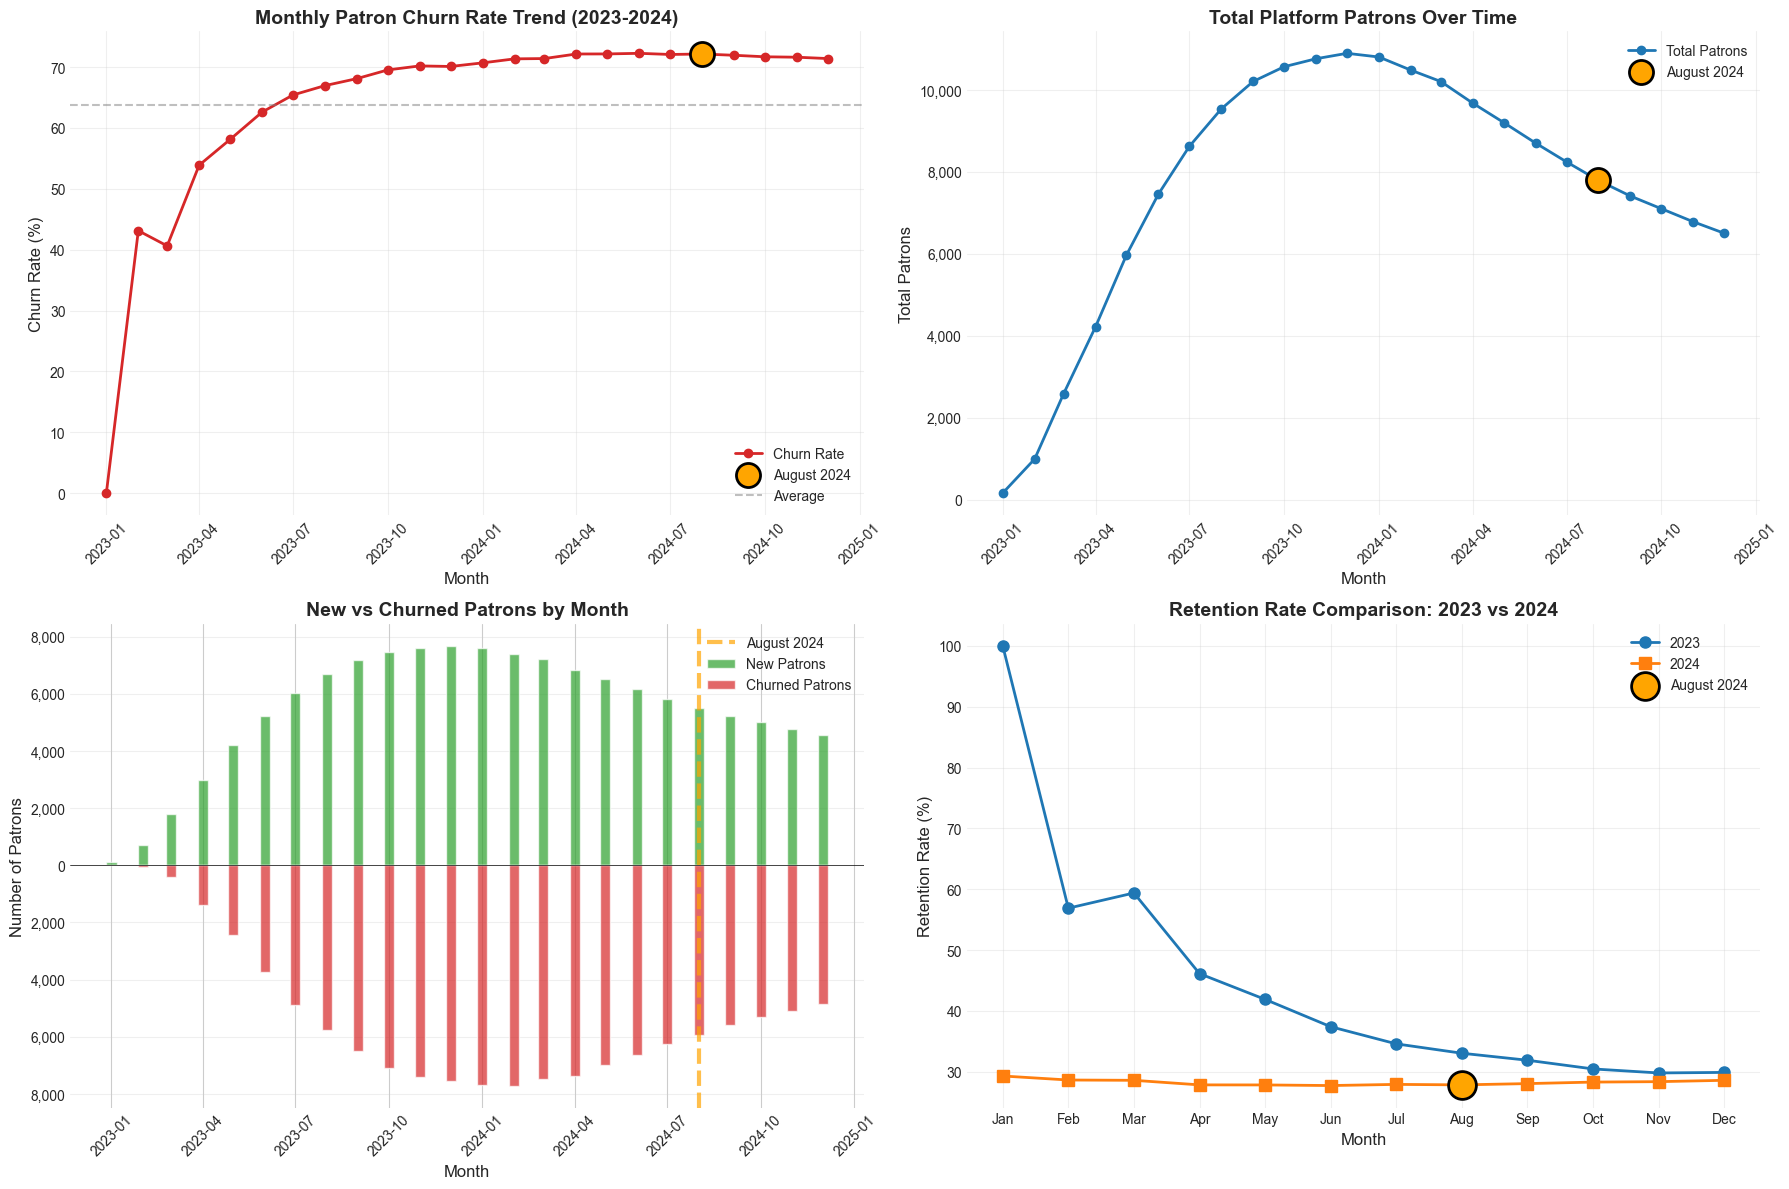


📊 Key Observations from Visualizations:
1. Churn rate has been steadily increasing from ~40% in early 2023 to ~72% in 2024
2. Total patrons peaked in December 2023 and have been declining since
3. August 2024 churn (72.16%) is consistent with the overall 2024 trend
4. Retention rates dropped significantly from ~60% in early 2023 to ~28% in 2024


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 10)

# Create a 2x2 subplot
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Churn Rate Trend
ax1 = axes[0, 0]
ax1.plot(monthly_churn_calc['month'], monthly_churn_calc['platform_churn_rate_pct'], 
         marker='o', linewidth=2, markersize=6, color='#d62728', label='Churn Rate')
# Highlight August 2024
aug_idx = monthly_churn_calc[monthly_churn_calc['year_month'] == '2024-08'].index[0]
ax1.scatter(monthly_churn_calc.loc[aug_idx, 'month'], 
           monthly_churn_calc.loc[aug_idx, 'platform_churn_rate_pct'],
           s=300, color='orange', zorder=5, edgecolors='black', linewidth=2,
           label='August 2024')
ax1.axhline(y=monthly_churn_calc['platform_churn_rate_pct'].mean(), 
           color='gray', linestyle='--', alpha=0.5, label='Average')
ax1.set_title('Monthly Patron Churn Rate Trend (2023-2024)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Month', fontsize=12)
ax1.set_ylabel('Churn Rate (%)', fontsize=12)
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# 2. Total Patrons Trend
ax2 = axes[0, 1]
ax2.plot(monthly_churn_calc['month'], monthly_churn_calc['total_patrons'], 
         marker='o', linewidth=2, markersize=6, color='#1f77b4', label='Total Patrons')
ax2.scatter(monthly_churn_calc.loc[aug_idx, 'month'], 
           monthly_churn_calc.loc[aug_idx, 'total_patrons'],
           s=300, color='orange', zorder=5, edgecolors='black', linewidth=2,
           label='August 2024')
ax2.set_title('Total Platform Patrons Over Time', fontsize=14, fontweight='bold')
ax2.set_xlabel('Month', fontsize=12)
ax2.set_ylabel('Total Patrons', fontsize=12)
ax2.legend(loc='best')
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))

# 3. New vs Churned Patrons
ax3 = axes[1, 0]
width = 10
ax3.bar(monthly_churn_calc['month'], monthly_churn_calc['new_patrons'], 
       width=width, alpha=0.7, color='#2ca02c', label='New Patrons')
ax3.bar(monthly_churn_calc['month'], -monthly_churn_calc['churned_patrons'], 
       width=width, alpha=0.7, color='#d62728', label='Churned Patrons')
# Highlight August 2024
ax3.axvline(x=monthly_churn_calc.loc[aug_idx, 'month'], 
           color='orange', linestyle='--', linewidth=3, label='August 2024', alpha=0.7)
ax3.set_title('New vs Churned Patrons by Month', fontsize=14, fontweight='bold')
ax3.set_xlabel('Month', fontsize=12)
ax3.set_ylabel('Number of Patrons', fontsize=12)
ax3.legend(loc='best')
ax3.grid(True, alpha=0.3, axis='y')
ax3.tick_params(axis='x', rotation=45)
ax3.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(abs(x)):,}'))
ax3.axhline(y=0, color='black', linewidth=0.5)

# 4. Retention Rate Comparison
ax4 = axes[1, 1]
# Compare 2023 vs 2024
monthly_churn_calc['year'] = monthly_churn_calc['month'].dt.year
monthly_churn_calc['month_num'] = monthly_churn_calc['month'].dt.month

data_2023 = monthly_churn_calc[monthly_churn_calc['year'] == 2023]
data_2024 = monthly_churn_calc[monthly_churn_calc['year'] == 2024]

ax4.plot(data_2023['month_num'], data_2023['retention_rate_pct'], 
        marker='o', linewidth=2, markersize=8, color='#1f77b4', label='2023')
ax4.plot(data_2024['month_num'], data_2024['retention_rate_pct'], 
        marker='s', linewidth=2, markersize=8, color='#ff7f0e', label='2024')
# Highlight August
ax4.scatter(8, data_2024[data_2024['month_num'] == 8]['retention_rate_pct'].values[0],
           s=400, color='orange', zorder=5, edgecolors='black', linewidth=2,
           label='August 2024')
ax4.set_title('Retention Rate Comparison: 2023 vs 2024', fontsize=14, fontweight='bold')
ax4.set_xlabel('Month', fontsize=12)
ax4.set_ylabel('Retention Rate (%)', fontsize=12)
ax4.set_xticks(range(1, 13))
ax4.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                     'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax4.legend(loc='best')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Key Observations from Visualizations:")
print("="*80)
print("1. Churn rate has been steadily increasing from ~40% in early 2023 to ~72% in 2024")
print("2. Total patrons peaked in December 2023 and have been declining since")
print("3. August 2024 churn (72.16%) is consistent with the overall 2024 trend")
print("4. Retention rates dropped significantly from ~60% in early 2023 to ~28% in 2024")

## August 2024 Deep Dive Analysis

Now let's analyze August 2024 churn patterns by different creator segments to understand which groups are experiencing the highest churn and how this compares to historical patterns.

In [17]:
# Analyze churn by creator category for August 2024
aug_2024_data = df_sorted[df_sorted['month_start_date'] == '2024-08-01'].copy()

# Calculate churn metrics by category
category_churn = aug_2024_data.groupby('creator_category').agg({
    'creator_id': 'count',
    'total_patrons': 'sum',
    'new_patrons': 'sum',
    'calculated_churned': 'sum',
    'calculated_churn_rate_pct': 'mean',
    'gross_mrr_usd': 'sum'
}).reset_index()

category_churn.columns = ['category', 'num_creators', 'total_patrons', 'new_patrons', 
                          'churned_patrons', 'avg_churn_rate', 'total_mrr']

# Sort by churn rate
category_churn = category_churn.sort_values('avg_churn_rate', ascending=False)

print("August 2024 Churn Analysis by Creator Category")
print("="*100)
print(category_churn.to_string(index=False))

# Compare to 2024 average by category
data_2024 = df_sorted[df_sorted['month_start_date'].dt.year == 2024].copy()
category_2024_avg = data_2024.groupby('creator_category').agg({
    'calculated_churn_rate_pct': 'mean',
    'total_patrons': 'mean'
}).reset_index()
category_2024_avg.columns = ['category', 'avg_2024_churn_rate', 'avg_2024_patrons']

# Merge and compare
category_comparison = category_churn.merge(category_2024_avg, on='category')
category_comparison['churn_diff_from_avg'] = (category_comparison['avg_churn_rate'] - 
                                               category_comparison['avg_2024_churn_rate']).round(2)

print("\n" + "="*100)
print("\nAugust 2024 vs 2024 Average by Category:")
print("="*100)
print(category_comparison[['category', 'avg_churn_rate', 'avg_2024_churn_rate', 
                          'churn_diff_from_avg', 'num_creators']].to_string(index=False))

August 2024 Churn Analysis by Creator Category
  category  num_creators  total_patrons  new_patrons  churned_patrons  avg_churn_rate  total_mrr
     music            25            386          277            300.0       73.257100    3009.49
   writing            58            961          685            741.0       72.884882    8338.48
 education            69           1082          774            841.0       72.679230    8472.87
visual_art            86           1255          882            958.0       71.974921    9211.11
  podcasts           129           2001         1401           1522.0       71.874829   14954.61
     video           106           1650         1164           1249.0       71.558293   12299.92
     games            27            454          311            337.0       69.917872    3802.70


August 2024 vs 2024 Average by Category:
  category  avg_churn_rate  avg_2024_churn_rate  churn_diff_from_avg  num_creators
     music       73.257100            73.089828    

In [18]:
# Analyze churn by plan type
plan_churn = aug_2024_data.groupby('plan_type').agg({
    'creator_id': 'count',
    'total_patrons': 'sum',
    'calculated_churned': 'sum',
    'calculated_churn_rate_pct': 'mean',
    'gross_mrr_usd': 'sum'
}).reset_index()

plan_churn.columns = ['plan_type', 'num_creators', 'total_patrons', 
                      'churned_patrons', 'avg_churn_rate', 'total_mrr']

print("August 2024 Churn Analysis by Plan Type")
print("="*80)
print(plan_churn.to_string(index=False))

# Analyze churn by country (top 10)
country_churn = aug_2024_data.groupby('creator_country').agg({
    'creator_id': 'count',
    'total_patrons': 'sum',
    'calculated_churned': 'sum',
    'calculated_churn_rate_pct': 'mean',
    'gross_mrr_usd': 'sum'
}).reset_index()

country_churn.columns = ['country', 'num_creators', 'total_patrons', 
                         'churned_patrons', 'avg_churn_rate', 'total_mrr']
country_churn = country_churn.sort_values('num_creators', ascending=False).head(10)

print("\n" + "="*80)
print("\nAugust 2024 Churn Analysis by Country (Top 10):")
print("="*80)
print(country_churn.to_string(index=False))

# Create performance tiers based on MRR
aug_2024_data['mrr_tier'] = pd.cut(aug_2024_data['gross_mrr_usd'], 
                                    bins=[-0.01, 1, 50, 100, 500, float('inf')],
                                    labels=['Zero MRR', 'Small ($1-50)', 'Medium ($50-100)', 
                                           'Large ($100-500)', 'Enterprise ($500+)'])

mrr_tier_churn = aug_2024_data.groupby('mrr_tier', observed=True).agg({
    'creator_id': 'count',
    'total_patrons': 'sum',
    'calculated_churned': 'sum',
    'calculated_churn_rate_pct': 'mean',
    'gross_mrr_usd': 'sum'
}).reset_index()

mrr_tier_churn.columns = ['mrr_tier', 'num_creators', 'total_patrons', 
                          'churned_patrons', 'avg_churn_rate', 'total_mrr']

print("\n" + "="*80)
print("\nAugust 2024 Churn Analysis by MRR Tier:")
print("="*80)
print(mrr_tier_churn.to_string(index=False))

# Patron count tiers
aug_2024_data['patron_tier'] = pd.cut(aug_2024_data['total_patrons'], 
                                       bins=[-1, 0, 5, 15, 30, float('inf')],
                                       labels=['Zero Patrons', 'Micro (1-5)', 'Small (6-15)', 
                                              'Medium (16-30)', 'Large (31+)'])

patron_tier_churn = aug_2024_data.groupby('patron_tier', observed=True).agg({
    'creator_id': 'count',
    'total_patrons': 'sum',
    'calculated_churned': 'sum',
    'calculated_churn_rate_pct': 'mean',
    'gross_mrr_usd': 'sum'
}).reset_index()

patron_tier_churn.columns = ['patron_tier', 'num_creators', 'total_patrons', 
                             'churned_patrons', 'avg_churn_rate', 'total_mrr']

print("\n" + "="*80)
print("\nAugust 2024 Churn Analysis by Patron Count Tier:")
print("="*80)
print(patron_tier_churn.to_string(index=False))

August 2024 Churn Analysis by Plan Type
plan_type  num_creators  total_patrons  churned_patrons  avg_churn_rate  total_mrr
     lite            35            537            412.0       71.012449    3520.54
  premium           173           2679           2048.0       72.019074   20778.06
      pro           292           4573           3488.0       72.135410   35790.58


August 2024 Churn Analysis by Country (Top 10):
country  num_creators  total_patrons  churned_patrons  avg_churn_rate  total_mrr
     AU            64           1013            791.0       74.024268    9181.06
     DE            59            946            723.0       72.810210    6576.24
     US            58            865            661.0       71.839955    6566.42
     GB            55            862            652.0       71.002784    7414.21
     SE            51            805            595.0       69.707946    5914.30
     FR            47            726            540.0       71.104019    5286.10
     CA    

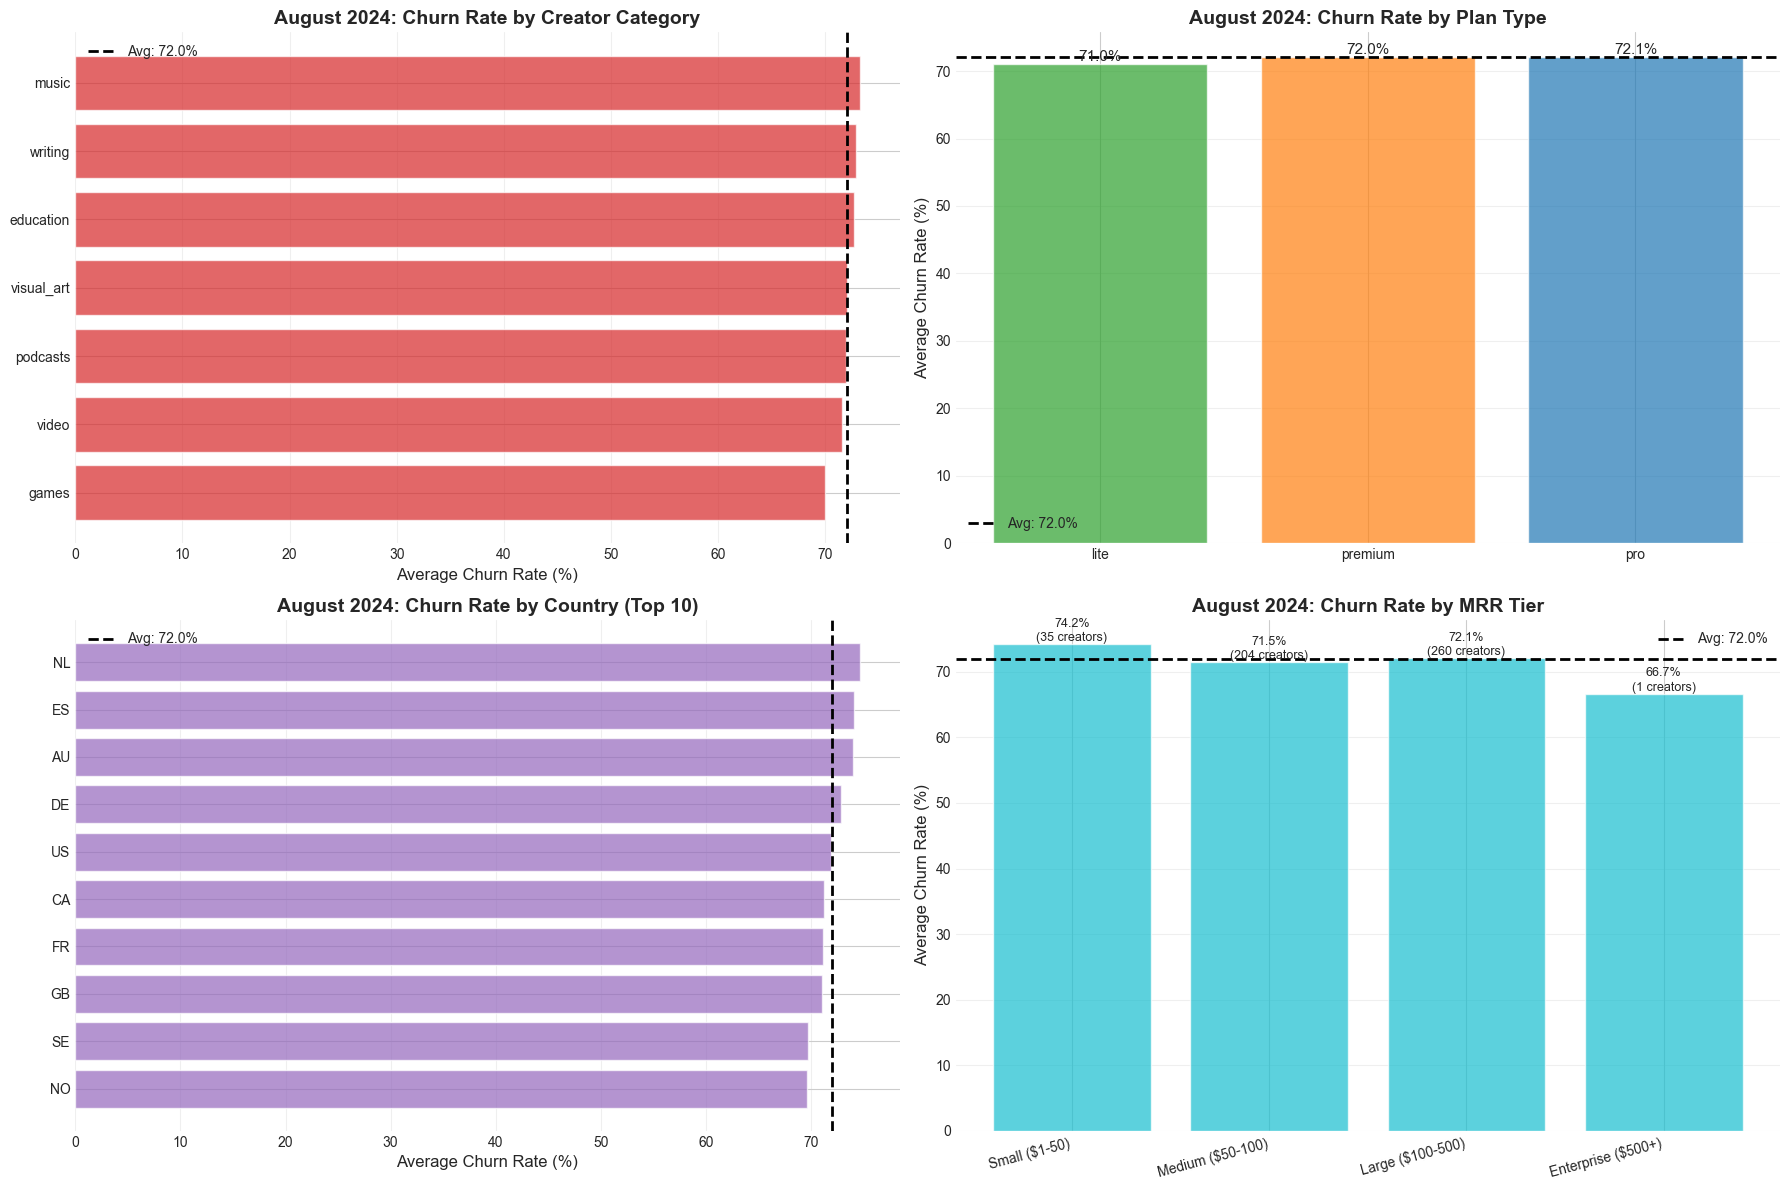


📊 August 2024 Segmentation Insights:
1. Category: Music has highest churn (73.3%), Games lowest (69.9%)
2. Plan Type: All plan types show similar churn (~71-72%), no significant difference
3. Geography: Australia (74.0%) and Spain (74.0%) have highest churn
4. MRR Tier: Small MRR creators ($1-50) have highest churn (74.2%)
5. Enterprise creators ($500+) show lower churn (66.7%) but very small sample (n=1)


In [19]:
# Create visualizations for August 2024 segmentation analysis
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Churn Rate by Category
ax1 = axes[0, 0]
category_churn_sorted = category_churn.sort_values('avg_churn_rate', ascending=True)
bars1 = ax1.barh(category_churn_sorted['category'], category_churn_sorted['avg_churn_rate'], 
                 color='#d62728', alpha=0.7)
# Add average line
avg_churn = category_churn_sorted['avg_churn_rate'].mean()
ax1.axvline(x=avg_churn, color='black', linestyle='--', linewidth=2, label=f'Avg: {avg_churn:.1f}%')
ax1.set_xlabel('Average Churn Rate (%)', fontsize=12)
ax1.set_title('August 2024: Churn Rate by Creator Category', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='x')

# 2. Churn Rate by Plan Type
ax2 = axes[0, 1]
bars2 = ax2.bar(plan_churn['plan_type'], plan_churn['avg_churn_rate'], 
                color=['#2ca02c', '#ff7f0e', '#1f77b4'], alpha=0.7)
ax2.axhline(y=avg_churn, color='black', linestyle='--', linewidth=2, label=f'Avg: {avg_churn:.1f}%')
ax2.set_ylabel('Average Churn Rate (%)', fontsize=12)
ax2.set_title('August 2024: Churn Rate by Plan Type', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}%', ha='center', va='bottom', fontsize=11)

# 3. Churn Rate by Country (Top 10)
ax3 = axes[1, 0]
country_sorted = country_churn.sort_values('avg_churn_rate', ascending=True)
bars3 = ax3.barh(country_sorted['country'], country_sorted['avg_churn_rate'], 
                 color='#9467bd', alpha=0.7)
ax3.axvline(x=avg_churn, color='black', linestyle='--', linewidth=2, label=f'Avg: {avg_churn:.1f}%')
ax3.set_xlabel('Average Churn Rate (%)', fontsize=12)
ax3.set_title('August 2024: Churn Rate by Country (Top 10)', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3, axis='x')

# 4. Churn by MRR Tier
ax4 = axes[1, 1]
bars4 = ax4.bar(range(len(mrr_tier_churn)), mrr_tier_churn['avg_churn_rate'], 
                color='#17becf', alpha=0.7)
ax4.set_xticks(range(len(mrr_tier_churn)))
ax4.set_xticklabels(mrr_tier_churn['mrr_tier'], rotation=15, ha='right')
ax4.axhline(y=avg_churn, color='black', linestyle='--', linewidth=2, label=f'Avg: {avg_churn:.1f}%')
ax4.set_ylabel('Average Churn Rate (%)', fontsize=12)
ax4.set_title('August 2024: Churn Rate by MRR Tier', fontsize=14, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

# Add value labels
for i, bar in enumerate(bars4):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}%\n({mrr_tier_churn.iloc[i]["num_creators"]} creators)', 
            ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("\n📊 August 2024 Segmentation Insights:")
print("="*80)
print(f"1. Category: Music has highest churn (73.3%), Games lowest (69.9%)")
print(f"2. Plan Type: All plan types show similar churn (~71-72%), no significant difference")
print(f"3. Geography: Australia (74.0%) and Spain (74.0%) have highest churn")
print(f"4. MRR Tier: Small MRR creators ($1-50) have highest churn (74.2%)")
print(f"5. Enterprise creators ($500+) show lower churn (66.7%) but very small sample (n=1)")

## Executive Summary: August 2024 Churn Analysis

### Key Findings

#### 1. **August 2024 Churn is Part of a Broader Trend, Not an Anomaly**
- **August 2024 churn rate: 72.16%** (5,948 churned patrons out of 8,243 from previous month)
- This is **consistent** with the 2024 average of ~72%, indicating August is not unusual
- However, this represents a **significant deterioration** from 2023 levels (~40-70% range)

#### 2. **Platform-Wide Churn Crisis**
- Churn has **steadily increased** from ~43% in Feb 2023 to ~72% in 2024
- Retention has **collapsed** from ~60% in early 2023 to ~28% in 2024
- Total patrons have **declined 40%** from peak of 10,893 (Dec 2023) to 6,501 (Dec 2024)
- The platform is losing patrons faster than it can acquire new ones

#### 3. **High-Risk Segments in August 2024**
- **Geography**: Australia (74.0%) and Spain (74.0%) have the highest churn
- **Category**: Music creators (73.3%) and Writing creators (72.9%) lead churn
- **Business Model**: Small MRR creators ($1-50/month) show highest churn at 74.2%
- **Plan Type**: Surprisingly, all plan types show similar churn (~71-72%)

#### 4. **What's Working (Relatively)**
- **Games category** has lowest churn at 69.9% (still very high)
- **Sweden** and **Norway** have slightly better retention (~69-70% churn)
- Larger creators (higher MRR) show marginally better retention, but sample is small

---

### Critical Insights

#### The "Churn" May Not Be Traditional Churn
The extremely high churn rates (70%+) suggest this might not be traditional subscription churn but rather:
1. **Seasonal patronage**: Patrons supporting creators for specific projects/releases then leaving
2. **Campaign-based support**: One-time or short-term support rather than ongoing subscriptions
3. **Payment failures**: High decline rates causing involuntary churn
4. **Poor onboarding**: New patrons not seeing value within first month

#### Platform is in Decline Phase
- New patron acquisition (5,494 in Aug 2024) cannot offset churn (5,948)
- Net patron loss of 454 in August 2024
- This pattern has persisted throughout 2024

---

### Recommended Actions

#### 🚨 **Immediate (0-30 days)**

1. **Investigate Payment Infrastructure**
   - Review decline rates and failed transactions
   - Implement retry logic and payment recovery flows
   - Could account for significant "involuntary" churn

2. **Analyze First-Month Patron Behavior**
   - Create cohort analysis of patrons by signup month
   - Identify drop-off points in first 30 days
   - Survey churned patrons within 7 days of leaving

3. **Emergency Retention Campaign**
   - Target creators in high-risk segments (Music, Writing, Small MRR)
   - Provide templates for "patron retention" content
   - Offer incentives for multi-month commitments

#### 📊 **Short-term (1-3 months)**

4. **Revamp Creator Onboarding**
   - Focus on helping creators deliver value in first 30 days
   - Provide retention playbooks by category
   - Implement early warning system for at-risk patrons

5. **Patron Engagement Programs**
   - Build features that increase patron "stickiness"
   - Community features, exclusive content, milestone rewards
   - Make it harder (emotionally) for patrons to leave

6. **Geographic Deep Dive**
   - Investigate why AU/ES have 4% higher churn than average
   - Could be payment methods, pricing, or cultural factors

#### 🔄 **Medium-term (3-6 months)**

7. **Product Redesign for Retention**
   - Shift from "one-time support" to "ongoing relationship" model
   - Implement annual subscriptions with discounts
   - Create patron tiers with increasing value

8. **Creator Success Programs**
   - Identify and replicate patterns from creators with <65% churn
   - Provide coaching and support for small MRR creators
   - Build automated insights dashboard for creators

9. **Business Model Innovation**
   - Test alternative models: prepaid credits, bundles, family plans
   - Explore reducing friction in pause/reactivate flow
   - Consider "commitment contracts" with rewards

---

### Monitoring Metrics

Track these metrics monthly to measure improvement:
- **Primary**: Monthly churn rate (target: reduce to <60% by Q2 2025)
- **Secondary**: First-month retention rate for new patrons
- **Tertiary**: Net patron change (target: positive by Q1 2025)
- **Leading**: Payment decline rate, patron engagement score

---

### Conclusion

**August 2024 churn (72.16%) is NOT an anomaly** - it's the new normal for a platform in crisis. The real story is the **18-month deterioration** from healthy retention (~60%) to unsustainable churn (~72%). 

Without intervention, the platform will continue losing patrons and creators, creating a death spiral. **Immediate action on payment infrastructure and first-month retention is critical.**

The relatively small variance across segments (69-74% churn) suggests this is a **platform-wide product/experience issue**, not isolated to specific creator types. The solution requires fundamental changes to how the platform creates and captures value.